```python
"""
Dedalus script simulating a 2D periodic incompressible MHD flow with a passive
tracer field for visualization. This script demonstrates solving a 2D periodic
initial value problem. It can be ran serially or in parallel, and uses the
built-in analysis framework to save data snapshots to HDF5 files. The
`plot_snapshots.py` script can be used to produce plots from the saved data.
The simulation should take a few cpu-minutes to run.

The initial flow is in the x-direction and depends only on z. The problem is
non-dimensionalized usign the shear-layer spacing and velocity jump, so the
resulting viscosity and tracer diffusivity are related to the Reynolds and
Schmidt numbers as:

    nu = 1 / Re
    eta = 1 / ReM
    D = nu / Schmidt

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 shear_flow.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""
```

In [1]:
%matplotlib widget

In [1]:
import os
import glob
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dedalus.public as d3
from dedalus.extras import plot_tools
import pathlib
from docopt import docopt
from dedalus.tools import logging
from dedalus.tools import post
from dedalus.tools.parallel import Sync
import logging
from IPython.display import display
import imageio
from importlib import reload
from my_random_fields import GRF_Mattern
import torch
from functorch import vmap
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-08-25 09:28:13,735 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2022-08-25 09:28:13,737 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2022-08-25 09:28:13,861 numexpr.utils 0/1 INFO :: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-25 09:28:13,862 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


# Parameters

In [38]:
Lx, Ly = 1, 1
Nx, Ny = 128, 128
Re = 1e4
ReM = 1e4
Schmidt = 1
rho0 = 1.0
dealias = 3/2
stop_sim_time = 1
timestepper = d3.RK443 #d3.RK222
Dt = 1e-3
max_timestep = 1e-2
output_dt = 1e-2 # 1e-1
dtype = np.float64
max_writes = np.inf
logger = logging.getLogger(__name__)
output_dir = 'outputs_KHI_new_code_test'
# output_dir = 'outputs_random_new_code_test'

movie_dir = 'MHD_test_KHI/movie/'
sim_outputs = os.path.join(output_dir, '*.h5')
frame_dir = 'frames'



In [39]:
digits = 2
os.path.join(output_dir,f'output-{10:0{digits}d}')

'outputs_KHI_new_code_test/output-10'

# Bases

In [40]:
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)

# Fields

In [41]:
p = dist.Field(name='p', bases=(xbasis,ybasis))
s = dist.Field(name='s', bases=(xbasis,ybasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,ybasis))
B = dist.VectorField(coords, name='B', bases=(xbasis,ybasis))
A = dist.Field(name='A', bases=(xbasis,ybasis))
B2 = dist.Field(name='B2', bases=(xbasis,ybasis))
# b2 = dist.Field(name='b2', bases=(xbasis,ybasis))

u_pot = dist.Field(name='u_pot', bases=(xbasis,ybasis))
Ax = dist.Field(name='Ax', bases=(xbasis,ybasis))
Ay = dist.Field(name='Ay', bases=(xbasis,ybasis))
Bx = dist.Field(name='Bx', bases=(xbasis,ybasis))
By = dist.Field(name='By', bases=(xbasis,ybasis))

u0 = dist.VectorField(coords, name='u0', bases=(xbasis,ybasis))
ux = dist.Field(name='ux', bases=(xbasis,ybasis))
uy = dist.Field(name='uy', bases=(xbasis,ybasis))


tau_p = dist.Field(name='tau_p')
# tau_B = dist.VectorField(coords,name='tau_B', bases=(xbasis,ybasis)) # Probably unused


# Substitutions

In [42]:
nu = 1 / Re
D = nu / Schmidt
eta = 1 / ReM
x, y = dist.local_grids(xbasis, ybasis)
X, Y = np.meshgrid(x, y, indexing='ij')
ex, ey = coords.unit_vector_fields(dist)
# ez = d3.CrossProduct(ex, ey)
curl2d_scalar = lambda x: - d3.skew(d3.grad(x))
curl2d_vector = lambda x: - d3.div(d3.skew(x))
B = curl2d_scalar(A)
B2 = d3.dot(B,B)
# b2 = d3.dot(B,B)
Bx = B@ex
By = B@ey
ux = u@ex
uy = u@ey
b2 = B@B

In [43]:
b2

Dot(Mul(-1, Skew(Grad(<Field 22475235336944>))), Mul(-1, Skew(Grad(<Field 22475235336944>))))

# Problem

In [24]:
# problem = d3.IVP([u, s, p, B, tau_p], namespace=locals())
problem = d3.IVP([u, p, A, tau_p, s], namespace=locals())
# problem = d3.IVP([u, p, A, tau_p], namespace=locals())

problem.add_equation("dt(u) + grad(p) - nu*lap(u) = - u@grad(u) - B@grad(B)")
problem.add_equation("dt(s) - D*lap(s) = - u@grad(s)")
# problem.add_equation("dt(B) - eta*lap(B) = B@grad(u) - u@grad(B)")
problem.add_equation("dt(A) - eta*lap(A) = u@grad(A)")
problem.add_equation("div(u) + tau_p = 0")
# problem.add_equation("div(B) = 0")
# problem.add_equation("div(B) + tau_B = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

In [44]:
problem = d3.IVP([u, p, A, tau_p, s], namespace=locals())
problem.add_equation("dt(u) + grad(p)/rho0 - nu*lap(u) = -0.5*grad(B2)/rho0 - u@grad(u) + B@grad(B)/rho0")
problem.add_equation("dt(s) - D*lap(s) = - u@grad(s)")
problem.add_equation("dt(A) - eta*lap(A) = - u@grad(A)")
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge


# Solver

In [45]:
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2022-08-25 09:36:26,258 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.3e+01/s
2022-08-25 09:36:26,401 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.0e+01/s
2022-08-25 09:36:26,566 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.1e+01/s
2022-08-25 09:36:26,729 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s
2022-08-25 09:36:26,893 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s
2022-08-25 09:36:27,057 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s
2022-08-25 09:36:27,221 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s
2022-08-25 09:36:27,383 subsystems 0/1 INFO :: Building subproblem matri

In [46]:
problem.variables

[<Field 22475236836112>,
 <Field 22475237807952>,
 <Field 22475235336944>,
 <Field 22475253740064>,
 <Field 22475237804448>]

# Initial conditions

### KHI Test

In [47]:
B0 = 1e-3
nx = 2
ny = 2
nx_mag = 1
ny_mag = 1
ux0 = 0.5
uy0 = 0.1
a_l = 0.01
sigma = 0.1
y_l = 0.25
x_shift = x - 0.5
y_shift = y - 0.5

kx = 2*np.pi*nx/Lx
ky = 2*np.pi*ny/Ly
kx_mag = 2*np.pi*nx_mag/Lx
ky_mag = 2*np.pi*ny_mag/Ly

In [48]:
u0 = ux0 * np.tanh(-(abs(y_shift) - y_l)/a_l)
# u0 = ux0*np.sign(y_shift) * np.tanh((y_shift - np.sign(y_shift)*y_l)/a_l)

u1 = uy0 * np.sign(y_shift) * np.sin(kx*x) * np.exp(-((abs(y_shift) - y_l)/sigma)**2)

# A['g'] = B0*(np.cos(2*np.pi*nx_mag*x/Lx)/(2*np.pi*nx_mag) + np.cos(2*np.pi*ny_mag*y/Ly)/(2*np.pi*ny_mag))
kx_mag = 2*np.pi*nx_mag/Lx
ky_mag = 2*np.pi*ny_mag/Ly
A0 = B0*(np.cos(kx_mag*x)/kx_mag + np.cos(ky_mag*y_shift)/ky_mag)

Text(0.5, 1.0, 'u1')

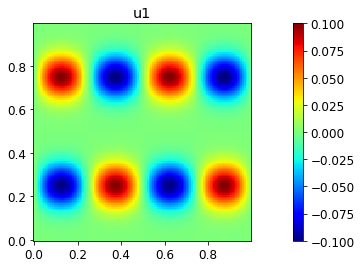

In [49]:
X, Y = np.meshgrid(x, y, indexing='ij')

pmesh = plt.pcolormesh(X, Y, u1, cmap='jet')
plt.colorbar(pmesh)
plt.axis('square')
plt.title('u1')


Text(0.5, 1.0, 'A0')

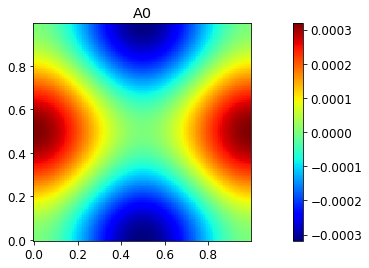

In [50]:
pmesh = plt.pcolormesh(X, Y, A0, cmap='jet')
plt.colorbar(pmesh)
plt.axis('square')
plt.title('A0')

In [51]:
# Background shear
u['g'][0] = u0
# # Match tracer to shear
s['g'] = u['g'][0]
# Add small vertical velocity perturbations localized to the shear layers
u['g'][1] = u1
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(y+0.5)**2/0.01)


# A['g'] = B0*(np.cos(2*np.pi*nx_mag*x/Lx)/(2*np.pi*nx_mag) + np.cos(2*np.pi*ny_mag*y/Ly)/(2*np.pi*ny_mag))
A['g'] = A0

In [52]:
# # Background shear
# u['g'][0] = 1/2 + 1/2 * (np.tanh((y-0.5)/0.1) - np.tanh((y+0.5)/0.1))
# # # Match tracer to shear
# s['g'] = u['g'][0]
# # Add small vertical velocity perturbations localized to the shear layers
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(y-0.5)**2/0.01)
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(y+0.5)**2/0.01)


# A['g'] = B0*(np.cos(2*np.pi*nx_mag*x/Lx)/(2*np.pi*nx_mag) + np.cos(2*np.pi*ny_mag*y/Ly)/(2*np.pi*ny_mag))

(<Axes:xlabel='x', ylabel='y'>, <Axes:xlabel='s'>)

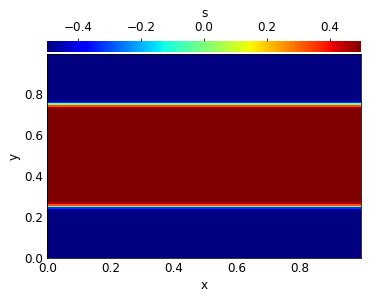

In [53]:
plot_tools.plot_bot_2d(s, cmap='jet')

(<Axes:xlabel='x', ylabel='y'>, <Axes:xlabel='A'>)

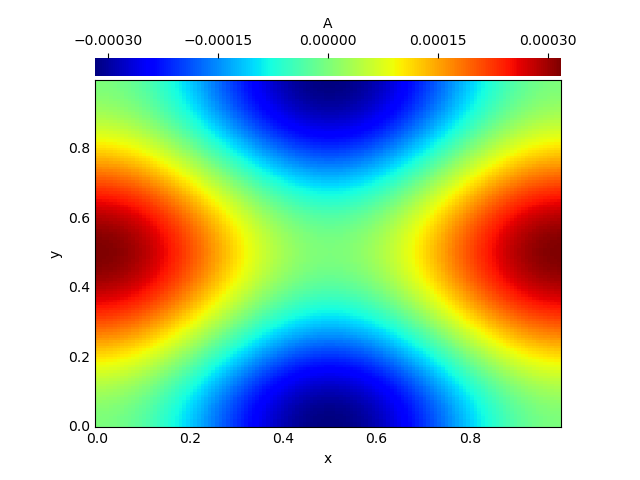

In [81]:
plot_tools.plot_bot_2d(A, cmap='jet')

In [54]:
# # Background shear
# u['g'][0] = 1/2 + 1/2 * (np.tanh((x-0.5)/0.1) - np.tanh((x+0.5)/0.1))
# # Match tracer to shear
# s['g'] = u['g'][0]
# # Add small vertical velocity perturbations localized to the shear layers
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(x-0.5)**2/0.01)
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(x+0.5)**2/0.01)
# # A['g'] = 0.001 * y 

### Random Initial Data

In [11]:
L = 1
dim = 2
Nsamples = 1
l = 0.1
Nu = None
sigma_u = 0.1
sigma_A = 5e-3

grf_u = GRF_Mattern(dim, Nx, length=Lx, nu=Nu, l=l, sigma=sigma_u, boundary="periodic", device=device)
grf_A = GRF_Mattern(dim, Nx, length=Lx, nu=Nu, l=l, sigma=sigma_A, boundary="periodic", device=device)

u0_pot = grf_u.sample(Nsamples).cpu().numpy().reshape(Nx,Ny)
A0 = grf_A.sample(Nsamples).cpu().numpy().reshape(Nx,Ny)

In [12]:
u_pot['g'] = u0_pot
u0 = curl2d_scalar(u_pot).evaluate()

In [13]:
u0.change_scales(1)
u0['g'].shape

(2, 128, 128)

In [14]:
# u_pot['g'] = u0_pot
# u0 = curl2d_scalar(u_pot).evaluate()
# u0.change_scales(1)

In [15]:
u['g'] = u0['g']
ux = u@ex
uy = u@ey
s['g'] = u0_pot
A['g'] = A0

In [16]:
u0_pot.reshape(Nx,Ny).shape

(128, 128)

Text(0.5, 1.0, 'u0_pot')

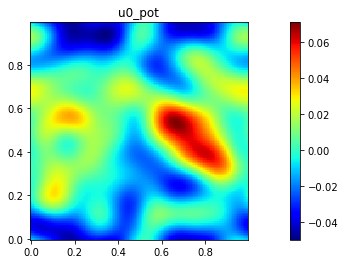

In [17]:
plt.figure()
pmesh = plt.pcolormesh(X, Y, u0_pot, cmap='jet')
plt.colorbar(pmesh)
plt.axis('square')
plt.title('u0_pot')
# plt.show()

In [18]:
u['g'].max()

0.7754119922300857

In [19]:
u['g'].shape

(2, 128, 128)

Text(0.5, 1.0, 'A0')

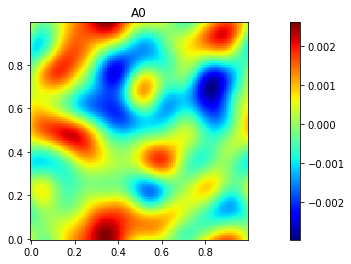

In [20]:
plt.figure()
pmesh = plt.pcolormesh(X, Y, A0, cmap='jet')
plt.colorbar(pmesh)
plt.axis('square')
plt.title('A0')

(<Axes:xlabel='x', ylabel='y'>, <Axes:xlabel='u@ex'>)

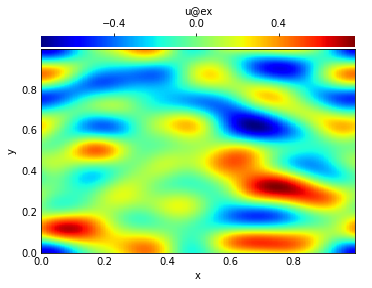

In [21]:
plot_tools.plot_bot_2d(ux.evaluate(), cmap='jet')

# Analysis (This overwrites existing files)

In [55]:
snapshots = solver.evaluator.add_file_handler(output_dir, sim_dt=output_dt, max_writes=max_writes)
# snapshots = solver.evaluator.add_file_handler(output_dir, sim_dt=0.1, max_writes=max_writes, mode='append')

snapshots.add_task(s, name='tracer')
snapshots.add_task(A, name='vector potential')
snapshots.add_task(B, name='magnetic field')
snapshots.add_task(Bx, name='Bx')
snapshots.add_task(By, name='By')
snapshots.add_task(d3.dot(B,B), name='B2')
snapshots.add_task(d3.div(B), name='divB')
snapshots.add_task(u, name='velocity')
snapshots.add_task(p, name='pressure')
snapshots.add_task(curl2d_vector(u), name='vorticity')
# snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [56]:
snapshots.get_file()

<HDF5 file "outputs_KHI_new_code_test_s1_p0.h5" (mode r+)>

In [57]:
# snapshots = solver.evaluator.add_file_handler(output_dir, sim_dt=0.1, max_writes=max_writes)
# # snapshots = solver.evaluator.add_file_handler(output_dir, sim_dt=0.01, max_writes=max_writes, mode='append')

# snapshots.add_task(A, name='vector potential')
# snapshots.add_task(u, name='veloc')
# snapshots.add_task(p, name='pressure')
# snapshots.add_task(curl2d_vector(u), name='vorticity')

# CFL

In [58]:
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.2, threshold=0.1,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties

In [59]:
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(d3.dot(u,u), name='w2')
flow.add_property(d3.dot(B,B), name='B2')
flow.add_property(d3.div(B), name='divB')


# Main loop

In [60]:
try:
    logger.info('Starting main loop')
    while solver.proceed:
#         timestep = CFL.compute_timestep()
        timestep = Dt
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_w = np.sqrt(flow.max('w2'))
            max_B = np.sqrt(flow.max('B2'))
            max_divB = flow.max('divB')
            logger.info(f'Iteration={solver.iteration}, Time={solver.sim_time}, dt={timestep}, max(w)={max_w}, max(B)={max_B}, max(div_B)={max_divB}')
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    if snapshots.dist.comm_cart.rank == 0:
        snapshots.process_virtual_file()
    solver.log_stats()

2022-08-25 09:36:53,784 __main__ 0/1 INFO :: Starting main loop
2022-08-25 09:36:54,222 __main__ 0/1 INFO :: Iteration=1, Time=0.001, dt=0.001, max(w)=0.5069980128097148, max(B)=0.001414213562373098, max(div_B)=6.635782363419583e-31
2022-08-25 09:36:55,095 __main__ 0/1 INFO :: Iteration=11, Time=0.011000000000000003, dt=0.001, max(w)=0.5280503265606806, max(B)=0.0017901451174027313, max(div_B)=7.587066189622451e-20
2022-08-25 09:36:55,984 __main__ 0/1 INFO :: Iteration=21, Time=0.02100000000000001, dt=0.001, max(w)=0.5281096682641849, max(B)=0.0021993116515870376, max(div_B)=2.6654678300831306e-19
2022-08-25 09:36:56,881 __main__ 0/1 INFO :: Iteration=31, Time=0.03100000000000002, dt=0.001, max(w)=0.5282475173912555, max(B)=0.0026259525409712157, max(div_B)=2.956934615535383e-19
2022-08-25 09:36:57,772 __main__ 0/1 INFO :: Iteration=41, Time=0.04100000000000003, dt=0.001, max(w)=0.5284268076972242, max(B)=0.003063807842773725, max(div_B)=2.6730248578628427e-19
2022-08-25 09:36:58,668 _

# Look at Results

In [61]:
# files = glob.glob(sim_outputs)
files = glob.glob(sim_outputs)
file = h5py.File(files[0], mode='r') 

In [62]:
w = file['tasks']['vorticity']

dims = w.dims
t = dims[0]['sim_time'][:]
x = dims[1][0][:]
y = dims[2][0][:]
divB = file['tasks']['divB'][:]

voticity = w[:]
pressure = file['tasks']['pressure'][:]
magnetic_field = file['tasks']['magnetic field'][:]
vector_potential = file['tasks']['vector potential'][:]
tracer = file['tasks']['tracer'][:]
display('w:', voticity.shape)
display('p:', pressure.shape)
display('A:', vector_potential.shape)
display('B:', magnetic_field.shape)
display('divB:', divB.shape)

'w:'

(100, 128, 128)

'p:'

(100, 128, 128)

'A:'

(100, 128, 128)

'B:'

(100, 2, 128, 128)

'divB:'

(100, 128, 128)

In [63]:
X, Y = np.meshgrid(x,y, indexing='ij')

In [64]:
voticity.shape

(100, 128, 128)

In [65]:
file.close()

In [66]:
def generate_movie_2D(data,
                      x, y, t,
                      plot_title='', 
                      xlabel='',
                      ylabel='',
                      show_time=False,
                      cmap='jet',
                      val_cbar_index=-1,
                      val_clim=None,
                      font_size=None, 
                      shrink=1.0,
                      aspect=20,
                      movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg',
                      remove_frames=True):
    
    frame_files = []
    
    if movie_dir:
        os.makedirs(movie_dir, exist_ok=True)
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    
    Nt, Nx, Ny = data.shape
    
#     x = torch.linspace(0, 1, Nx + 1)[:-1]
#     y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = np.meshgrid(x, y, indexing='ij')
#     t = torch.linspace(0, 1, Nt + 1)[:-1]
    Nt = len(t)
    
    fig, ax1 = plt.subplots(figsize=(6,5))
    plt.ion()
    
#     val_cmap = plt.cm.ScalarMappable(cmap=plt.cm.jet)
    
#     val_cmap.set_array(data[val_lim_index])
    
        

    pcm1 = ax1.pcolormesh(X, Y, data[val_cbar_index], cmap=cmap, label='data', shading='gouraud', antialiased=True)    


    if val_clim is  None:
        val_clim = pcm1.get_clim()

    pcm1.set_clim(val_clim)
    plt.colorbar(pcm1, ax=ax1, shrink=shrink, aspect=aspect)
    ax1.axis('square')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    if show_time:
        ax1.set_title(f'{plot_title}: $t={t[val_lim_index]:.2f}$')
    else:
        ax1.set_title(plot_title)
    
    plt.tight_layout()
#     fig.canvas.draw()
    for i in range(Nt):
        # Exact
        ax1.clear()
        pcm1 = ax1.pcolormesh(X, Y, data[i], cmap=cmap, label='data', shading='gouraud', antialiased=True)
#         ax1.set_zlim(val_zlim)
#         surf1.set_clim(val_clim)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
#         ax1.set_zlabel(zlabel)
        if show_time:
            ax1.set_title(f'{plot_title}: $t={t[i]:.2f}$')
        else:
            ax1.set_title(plot_title)

#         plt.tight_layout()
        fig.canvas.draw()
        fig.canvas.draw_idle()
        
        if movie_dir:
            frame_path = os.path.join(movie_dir,f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)

    

    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)
                
    if movie_dir and remove_frames:
        for frame in frame_files:
            try:
                os.remove(frame)
            except:
                pass
            
            
            
def generate_movie_2D_from_file(output_file, 
                                field,
                                plot_title='', 
                                xlabel='',
                                ylabel='',
                                show_time=False,
                                cmap='jet',
                                val_cbar_index=-1,
                                val_clim=None,
                                font_size=None, 
                                shrink=1.0,
                                aspect=20,
                                movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg',
                                remove_frames=True):
    
    with h5py.File(output_file, mode='r') as file:
        dat = file['tasks'][field]
        dims = dat.dims
        t = dims[0]['sim_time'][:]
        x = dims[1][0][:]
        y = dims[2][0][:]
        data = dat[:]
        
    generate_movie_2D(data,
                      x, y, t,
                      plot_title=plot_title, 
                      xlabel=xlabel,
                      ylabel=ylabel,
                      show_time=show_time,
                      cmap=cmap,
                      val_cbar_index=val_lim_index,
                      val_clim=val_clim,
                      movie_dir=movie_dir, 
                      movie_name=movie_name, 
                      frame_basename=frame_basename, 
                      frame_ext=frame_ext, 
                      font_size=font_size, 
                      shrink=shrink,
                      aspect=aspect,
                      remove_frames=remove_frames)



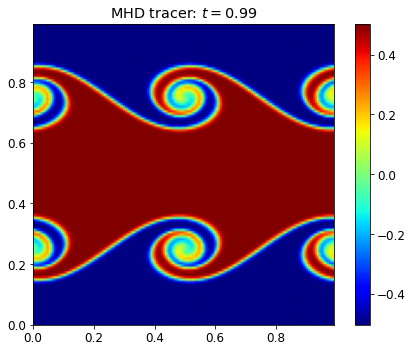

In [67]:
output_file = glob.glob(sim_outputs)[0]
# movie_dir = 'MHD_test/movie/'
if movie_dir:
    os.makedirs(movie_dir, exist_ok=True)
field = 'tracer'
movie_name = f'{field}.gif'
frame_basename = f'{field}_sim_frame'
frame_ext = 'jpg'
plot_title = f'MHD {field}'
xlabel = ''
ylabel = ''
# zlabel = f'$\eta$'
show_time = True
cmap = 'jet'
val_clim = None # [1.0, 1.05]
val_lim_index = -1
# err_lim_index = -1
font_size = 12
# remove_frames = False # True
remove_frames = True
shrink = 1
aspect = 20


generate_movie_2D_from_file(output_file=output_file,
                            field=field,
                            plot_title=plot_title, 
                            xlabel=xlabel,
                            ylabel=ylabel,
                            show_time=show_time,
                            val_cbar_index=val_lim_index,
                            val_clim=val_clim,
                            movie_dir=movie_dir, 
                            movie_name=movie_name, 
                            frame_basename=frame_basename, 
                            frame_ext=frame_ext, 
                            font_size=font_size, 
                            shrink=shrink,
                            aspect=aspect,
                            remove_frames=remove_frames)

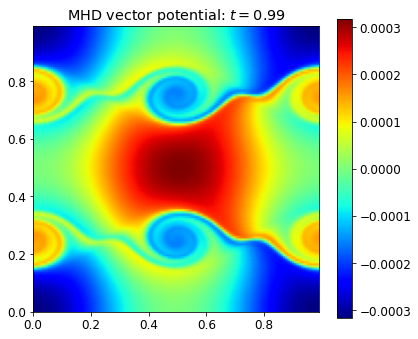

In [69]:
output_file = glob.glob(sim_outputs)[0]
# movie_dir = 'MHD_test/movie/'
os.makedirs(movie_dir, exist_ok=True)
field = 'vector potential'
movie_name = f'{field}.gif'
frame_basename = f'{field}_sim_frame'
frame_ext = 'jpg'
plot_title = f'MHD {field}'
xlabel = ''
ylabel = ''
show_time = True
cmap = 'jet'
val_clim = None # [1.0, 1.05]
val_lim_index = -1
font_size = 12
# remove_frames = False # True
remove_frames = True
shrink = 1
aspect = 20


generate_movie_2D_from_file(output_file=output_file,
                            field=field,
                            plot_title=plot_title, 
                            xlabel=xlabel,
                            ylabel=ylabel,
                            show_time=show_time,
                            val_cbar_index=val_lim_index,
                            val_clim=val_clim,
                            movie_dir=movie_dir, 
                            movie_name=movie_name, 
                            frame_basename=frame_basename, 
                            frame_ext=frame_ext, 
                            font_size=font_size, 
                            shrink=shrink,
                            aspect=aspect,
                            remove_frames=remove_frames)

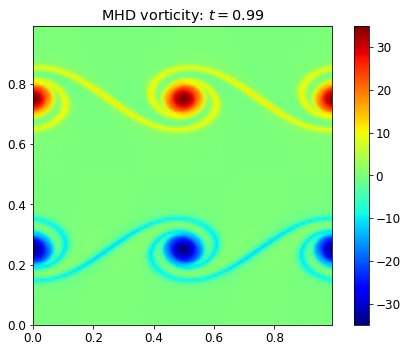

In [70]:
output_file = glob.glob(sim_outputs)[0]
# movie_dir = 'MHD_test/movie/'
if movie_dir:
    os.makedirs(movie_dir, exist_ok=True)
field = 'vorticity'
movie_name = f'{field}.gif'
frame_basename = f'{field}_sim_frame'
frame_ext = 'jpg'
plot_title = f'MHD {field}'
xlabel = ''
ylabel = ''
show_time = True
cmap = 'jet'
val_clim = None # [1.0, 1.05]
val_lim_index = -1
font_size = 12
# remove_frames = False # True
remove_frames = True
shrink = 1
aspect = 20


generate_movie_2D_from_file(output_file=output_file,
                            field=field,
                            plot_title=plot_title, 
                            xlabel=xlabel,
                            ylabel=ylabel,
                            show_time=show_time,
                            val_cbar_index=val_lim_index,
                            val_clim=val_clim,
                            movie_dir=movie_dir, 
                            movie_name=movie_name, 
                            frame_basename=frame_basename, 
                            frame_ext=frame_ext, 
                            font_size=font_size, 
                            shrink=shrink,
                            aspect=aspect,
                            remove_frames=remove_frames)

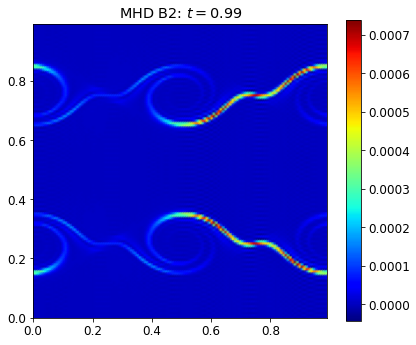

In [71]:
output_file = glob.glob(sim_outputs)[0]
# movie_dir = 'MHD_test/movie/'
# movie_dir = ''
if movie_dir:
    os.makedirs(movie_dir, exist_ok=True)
field = 'B2'
movie_name = f'{field}.gif'
frame_basename = f'{field}_sim_frame'
frame_ext = 'jpg'
plot_title = f'MHD {field}'
xlabel = ''
ylabel = ''
show_time = True
cmap = 'jet'
val_clim = None # [1.0, 1.05]
val_lim_index = -1
font_size = 12
# remove_frames = False # True
remove_frames = True
shrink = 1
aspect = 20


generate_movie_2D_from_file(output_file=output_file,
                            field=field,
                            plot_title=plot_title, 
                            xlabel=xlabel,
                            ylabel=ylabel,
                            show_time=show_time,
                            val_cbar_index=val_lim_index,
                            val_clim=val_clim,
                            movie_dir=movie_dir, 
                            movie_name=movie_name, 
                            frame_basename=frame_basename, 
                            frame_ext=frame_ext, 
                            font_size=font_size, 
                            shrink=shrink,
                            aspect=aspect,
                            remove_frames=remove_frames)

SyntaxError: invalid syntax (834105305.py, line 25)

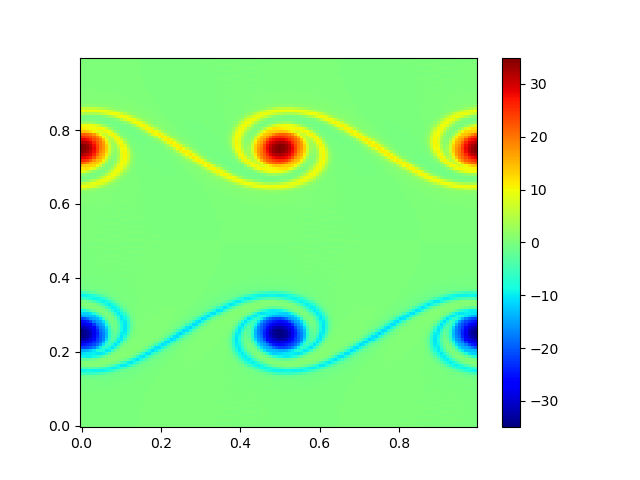

In [95]:
%matplotlib widget
fig = plt.figure()
plt.ion()
pmesh = plt.pcolormesh(X, Y, voticity[-1], cmap='jet')
plt.colorbar(pmesh)
fig.canvas.draw()
plt.show()

(-0.00390625, 0.99609375, -0.00390625, 0.99609375)

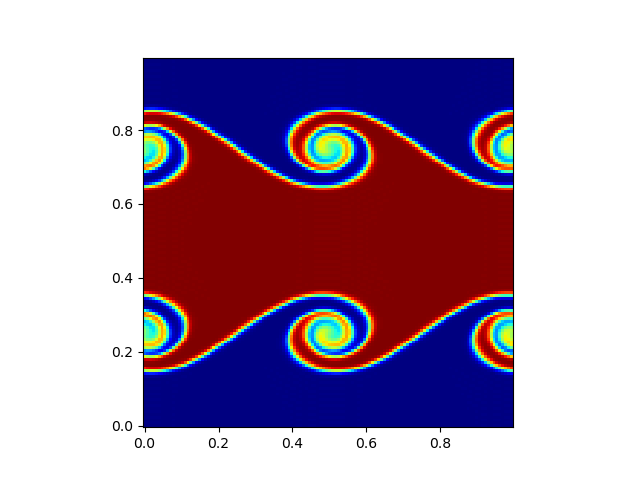

In [96]:
plt.figure()
plt.pcolormesh(X, Y, tracer[-1], cmap='jet')
plt.axis('square')

(-0.00390625, 0.99609375, -0.00390625, 0.99609375)

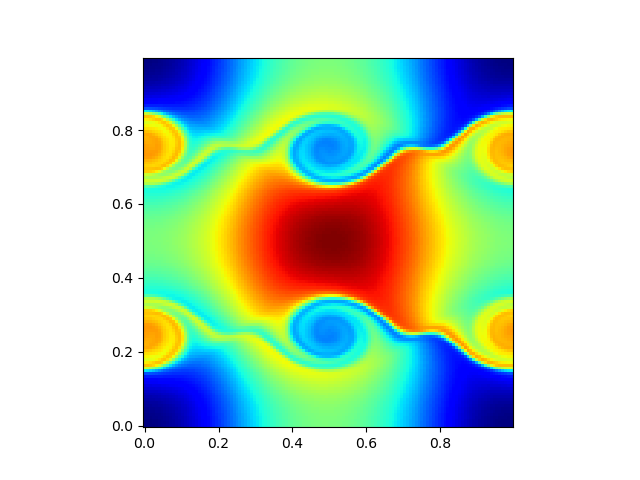

In [41]:
plt.figure()
plt.pcolormesh(X, Y, vector_potential[-1], cmap='jet')
plt.axis('square')
# vector_potential

In [204]:
def generate_single_movie_3D(data, 
                             plot_title='', 
                             xlabel='$x$',
                             ylabel='$y$',
                             zlabel='',
                             show_time=False,
                             val_lim_index=-1,
                             val_clim=None,
                             val_zlim=None, 
                             font_size=None, 
                             shrink=0.5,
                             aspect=5,
                             movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg',
                             remove_frames=True):
    frame_files = []
    
    if movie_dir:
        os.makedirs(movie_dir, exist_ok=True)
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    
    Nt, Nx, Ny = data.shape
    
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    t = torch.linspace(0, 1, Nt + 1)[:-1]
    
    
    fig, ax1 = plt.subplots(figsize=(6,5), subplot_kw={"projection": "3d"})
    
    val_cmap = plt.cm.ScalarMappable(cmap=plt.cm.jet)
    
    val_cmap.set_array(data[val_lim_index])
    
    if val_clim is not None:
        val_cmap.set_clim(val_clim)
        

    surf1 = ax1.plot_surface(X, Y, data[val_lim_index], cmap=val_cmap.cmap, norm=val_cmap.norm, linewidth=0, antialiased=True)
    


    if val_zlim is None:
        val_zlim = ax1.get_zlim()
    
    ax1.set_zlim(val_zlim)
    surf1.set_clim(val_clim)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_zlabel(zlabel)
    if show_time:
        ax1.set_title(f'{plot_title}: $t={t[val_lim_index]:.2f}$')
    else:
        ax1.set_title(plot_title)
    fig.colorbar(surf1, ax=ax1, shrink=shrink, aspect=aspect)
    
    plt.tight_layout()
#     fig.canvas.draw()
    for i in range(Nt):
        # Exact
        ax1.clear()
        surf1 = ax1.plot_surface(X, Y, data[i], cmap=val_cmap.cmap, norm=val_cmap.norm, label='true', linewidth=0, antialiased=True)
        ax1.set_zlim(val_zlim)
#         surf1.set_clim(val_clim)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_zlabel(zlabel)
        if show_time:
            ax1.set_title(f'{plot_title}: $t={t[i]:.2f}$')
        else:
            ax1.set_title(plot_title)

#         plt.tight_layout()
        fig.canvas.draw()
        
        if movie_dir:
            frame_path = os.path.join(movie_dir,f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)

    

    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)
                
    if movie_dir and remove_frames:
        for frame in frame_files:
            try:
                os.remove(frame)
            except:
                pass

# Plot Results

In [250]:
def plot_results(filename, start, count, output, tasks=None):
    """Save plot of specified tasks for given range of analysis writes."""

    # Plot settings
    if tasks is None:
        tasks = ['vector potential', 'vorticity', 'tracer']
    scale = 2
    dpi = 200
    title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
    savename_func = lambda write: 'write_{:06}.png'.format(write)
    # Layout
    nrows, ncols = 1, 3
    image = plot_tools.Box(1, 2)
    pad = plot_tools.Frame(0.2, 0, 0, 0)
    margin = plot_tools.Frame(0.2, 0.1, 0, 0)

    # Create multifigure
    mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
    fig = mfig.figure
    # Plot writes
    with h5py.File(filename, mode='r') as file:
        for index in range(start, start+count):
            for n, task in enumerate(tasks):
                # Build subfigure axes
                i, j = divmod(n, ncols)
                axes = mfig.add_axes(i, j, [0, 0, 1, 1])
                # Call 3D plotting helper, slicing in time
                dset = file['tasks'][task]
                plot_tools.plot_bot_3d(dset, 0, index, cmap='jet', axes=axes, title=task, even_scale=True, visible_axes=False)
            # Add time title
            title = title_func(file['scales/sim_time'][index])
            title_height = 1 - 0.5 * mfig.margin.top / mfig.fig.y
            fig.suptitle(title, x=0.45, y=title_height, ha='left')
            # Save figure
            savename = savename_func(file['scales/write_number'][index])
            savepath = output.joinpath(savename)
            fig.savefig(str(savepath), dpi=dpi)
            fig.clear()
    plt.close(fig)

In [251]:
frame_path = pathlib.Path(frame_dir).absolute()
files = glob.glob(sim_outputs)
# Create output directory if needed
with Sync() as sync:
    if sync.comm.rank == 0:
        os.makedirs(frame_path, exist_ok=True)
post.visit_writes(files, plot_results, output=frame_path)

2022-04-26 14:21:59,328 post 0/1 INFO :: Visiting set outputs/outputs_s1.h5 (start: 0, end: 100)


In [252]:
frames_dir2 = 'frames_mag'
tasks = ['B2', 'Bx', 'By']
frame_path = pathlib.Path(frames_dir2).absolute()
files = glob.glob(sim_outputs)
# Create output directory if needed
with Sync() as sync:
    if sync.comm.rank == 0:
        os.makedirs(frame_path, exist_ok=True)
post.visit_writes(files, plot_results, output=frame_path, tasks=tasks)

2022-04-26 14:23:10,890 post 0/1 INFO :: Visiting set outputs/outputs_s1.h5 (start: 0, end: 100)


In [253]:
# Plot settings
tasks = ['tracer', 'pressure', 'vorticity']
scale = 2
dpi = 200
title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
savename_func = lambda write: 'write_{:06}.png'.format(write)
# Layout
nrows, ncols = 1, 3
image = plot_tools.Box(1, 2)
pad = plot_tools.Frame(0.2, 0, 0, 0)
margin = plot_tools.Frame(0.2, 0.1, 0, 0)

# Create multifigure
mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
fig = mfig.figure
# Plot writes
with h5py.File(filename, mode='r') as file:
    for index in range(start, start+count):
        for n, task in enumerate(tasks):
            # Build subfigure axes
            i, j = divmod(n, ncols)
            axes = mfig.add_axes(i, j, [0, 0, 1, 1])
            # Call 3D plotting helper, slicing in time
            dset = file['tasks'][task]
            plot_tools.plot_bot_3d(dset, 0, index, cmap='jet', axes=axes, title=task, even_scale=True, visible_axes=False)
        # Add time title
        title = title_func(file['scales/sim_time'][index])
        title_height = 1 - 0.5 * mfig.margin.top / mfig.fig.y
        fig.suptitle(title, x=0.45, y=title_height, ha='left')
        # Save figure
        savename = savename_func(file['scales/write_number'][index])
        savepath = output.joinpath(savename)
        fig.savefig(str(savepath), dpi=dpi)
        fig.clear()
plt.close(fig)

NameError: name 'filename' is not defined

<Figure size 576x432 with 0 Axes>